In [65]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set the random seed for NumPy anf pyTorch
np.random.seed(42)
torch.manual_seed(42)

## Data Preprocessing

In [2]:
# Mnist digits dataset (Down)load
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
X = train_data.data
y = train_data.targets
X_test = test_data.data
y_test = test_data.targets

print('Train dataset shape: ', X.size())
print('Train labels shape: ', y.size())
print('Test dataset shape: ', X_test.size())
print('Test labels shape: ', y_test.size())

Train dataset shape:  torch.Size([60000, 28, 28])
Train labels shape:  torch.Size([60000])
Test dataset shape:  torch.Size([10000, 28, 28])
Test labels shape:  torch.Size([10000])


In [4]:
# Train adn validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.1, shuffle=True)

print('Train dataset shape: ', X_train.size())
print('Train labels shape: ', y_train.size())
print('Validation dataset shape: ', X_val.size())
print('Validation labels shape: ', y_val.size())

Train dataset shape:  torch.Size([54000, 28, 28])
Train labels shape:  torch.Size([54000])
Validation dataset shape:  torch.Size([6000, 28, 28])
Validation labels shape:  torch.Size([6000])


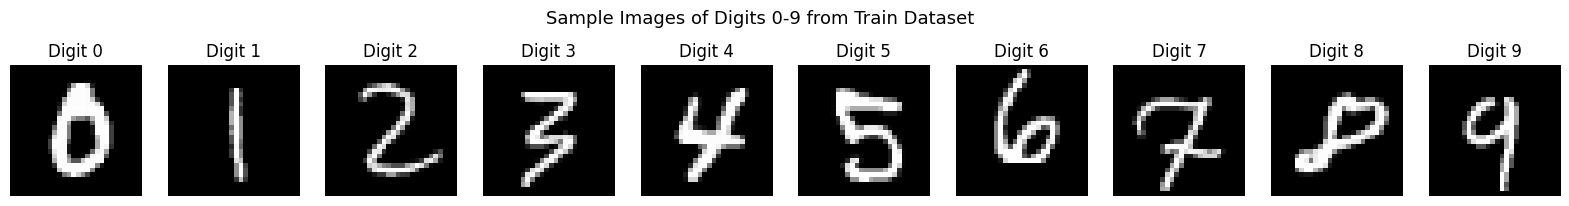

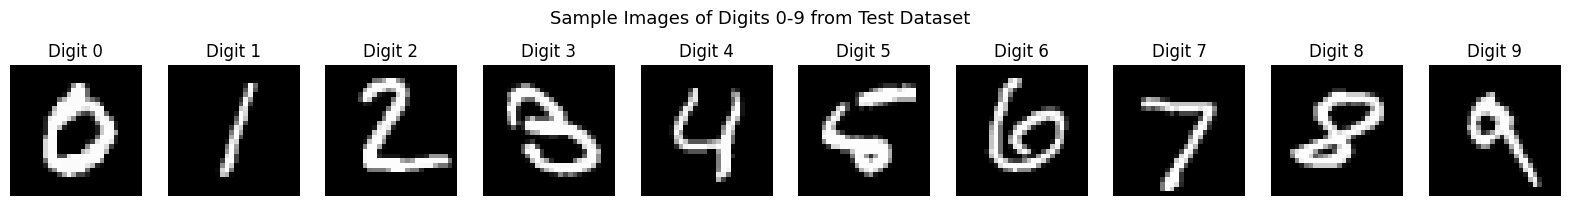

In [5]:
def show_sample_images(X, Y, train=True):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2.5))

    for i in range(10):
        for image, label in zip(X, Y):
            if label == i:
                digit_images = image
                break
        axes[i].imshow(digit_images.squeeze(), cmap='gray')
        axes[i].set_title(f'Digit {i}')
        axes[i].axis('off')
    
    fig.suptitle(f'Sample Images of Digits 0-9 from {"Train" if train else "Test"} Dataset', fontsize=13)
    plt.show()

show_sample_images(X_train, y_train, train=True)
show_sample_images(X_test, y_test, train=False)


### Distribution of Classes

The train and test datasets appear to be balanced, with each class containing approximately the same number of instances. Additionally, the distribution of data in the train and test sets is similar, so no further processing seems necessary in this regard.

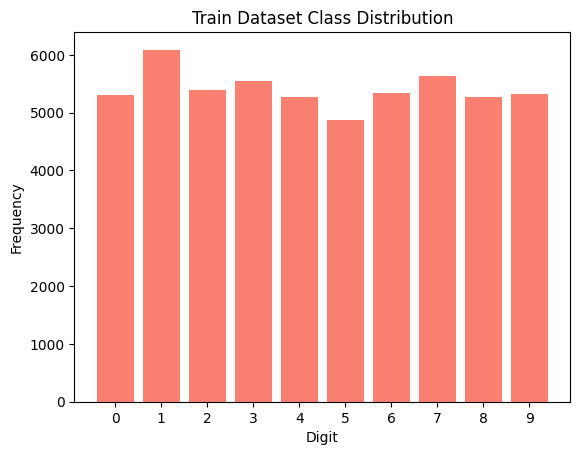

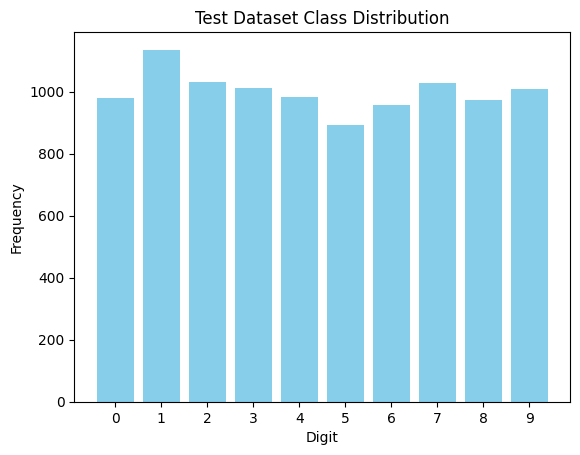

In [6]:
def plot_labels_histogram(Y, train=True):
    plt.hist(Y, bins=range(11), rwidth=0.8, align='left', color=f'{"salmon" if train else "skyblue"}')
    plt.xticks(range(10))
    plt.title(f'{"Train" if train else "Test"} Dataset Class Distribution')
    plt.xlabel('Digit')
    plt.ylabel('Frequency')
    plt.show()

plot_labels_histogram(y_train, train=True)
plot_labels_histogram(y_test, train=False)

### Normalization

We applied min-max normalization and constructed a TensorDataset for each of train, test and validation data for convenience. Why do we need to normalize our image data? 

1. **Improved Convergence in Training:** Neural networks, particularly deep networks, are sensitive to the range of input features. If the range of the input data is large or not standardized, it can lead to inefficient training and poor convergence. Scaling the data helps maintain numerical stability during the process of optimization (e.g., gradient descent). If feature values vary widely, the gradients can oscillate heavily, making it difficult for the model to converge.

2. **Uniformity Across Features:** Pixel values in MNIST images vary from 0 to 255. Normalizing these values to [0, 1] ensures a standardized input that the model can process uniformly. By scaling the input data, all features (pixel values) contribute equally to the training process, preventing any particular value from dominating the learning process due to its scale.

3. **Compatibility with Activation Functions:** Many commonly used activation functions (e.g., sigmoid, tanh, and even ReLU in some cases) work best with inputs that are within a certain range.

In [7]:
def mmNormalization(x):
    min_vals, _ = torch.min(x, dim=1, keepdim=True)
    max_vals, _ = torch.max(x, dim=1, keepdim=True)
    return (x-min_vals)/(max_vals-min_vals)

# flatten data from (size, 28, 28) to (size, 28*28) and apply min-max normalization
train_flatten = X_train.flatten(start_dim=1, end_dim=-1).type(torch.FloatTensor)
train_normalized = mmNormalization(train_flatten)
train_dataset = TensorDataset(train_normalized, y_train)

val_flatten = X_val.flatten(start_dim=1, end_dim=-1).type(torch.FloatTensor)
val_normalized = mmNormalization(val_flatten)
val_dataset = TensorDataset(val_normalized, y_val)

test_flatten = X_test.flatten(start_dim=1, end_dim=-1).type(torch.FloatTensor)
test_normalized = mmNormalization(test_flatten)
test_dataset = TensorDataset(test_normalized, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

## Autoencoder

Autoencoders are a type of neural network used for unsupervised learning, where the goal is to learn an efficient encoding (representation) of input data. They consist of two main parts: an encoder and a decoder. The encoder compresses the input data into a latent-space representation, and the decoder reconstructs the original data from this representation. 

**Autoencoder Architecture:**

***Encoder***
- **Input Layer**
    - `nn.Linear(28*28, 500)`: This layer transforms the 784-dimensional input into a 500-dimensional space.
    - `nn.ReLU()`: Applies the ReLU activation function to introduce non-linearity.

- **Hidden Layer 1:** 
  - `nn.Linear(500, 100)`: This layer reduces the 500-dimensional representation to 100 dimensions.
  - `nn.ReLU()`: Another ReLU activation for non-linearity.

- **Hidden Layer 2:** 
  - `nn.Linear(100, 30)`: This final layer compresses the 100-dimensional representation into a 30-dimensional latent space.

▶︎ Note on Encoder's Input:

  We argued in the previous exercise that output of each layer of a neural net is the input for the next layer so the sizes must be consistent. As we feed the network with a flattened array of image each time, the input is of shape $28*28=784$ so the first layer must be of shape $(784, x)$. The $x$ value depends on the input size of the next layer which, in our case, is $500$ so the first layer must be $(784, 500)$ in shape. The activation functions do not alter the layer's shape so we only need to focus passing the right dimentions to our FC layers, lowering it to $30$ for the encoder part of the encoder and increasing it to the desired output size which is the same as the input value of $784$.


***Decoder***

- **Input Layer:** The input to the decoder is the 30-dimensional latent representation.
  - `nn.Linear(30, 100)`: This layer transforms the 30-dimensional latent space back to 100 dimensions.
  - `nn.ReLU()`: Applies the ReLU activation function.

- **Hidden Layer 1:** 
  - `nn.Linear(100, 500)`: This layer expands the 100-dimensional representation to 500 dimensions.
  - `nn.ReLU()`: Another ReLU activation for non-linearity.

- **Hidden Layer 2:** 
  - `nn.Linear(500, 28*28)`: This final layer reconstructs the 500-dimensional representation back to the original 784-dimensional input space.
  - `nn.Sigmoid()`: Applies the Sigmoid activation function to ensure the output values are between 0 and 1, which is suitable for image pixel values.

***Autoencoder***

- **Initialization:** The `Autoencoder` class initializes an instance of the `Encoder` and `Decoder` classes.
- **Forward Pass:** The `forward` method defines the forward pass through the autoencoder:
  - The input `x` is passed through the encoder to obtain the latent representation.
  - The latent representation is then passed through the decoder to reconstruct the original input.
  - The method returns both the encoded (latent) representation and the decoded (reconstructed) output.

In [60]:
# Define the encoder architecture
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, 30)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# Define the decoder architecture
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),
            nn.Linear(100, 500),
            nn.ReLU(),
            nn.Linear(500, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

# Define the full autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [9]:
autoencoder = Autoencoder()
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=30, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=30, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=500, bias=True)
      (3): ReLU()
      (4): Linear(in_features=500, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


### Training

In [10]:
EPOCH = 15
LR = 0.001
N_TEST_IMG = 10
PATH_to_AE = './myAE.pth'

def plotDecodedImg(data, label, decoded, val=True):
    fig, ax = plt.subplots(1, N_TEST_IMG, figsize=(10, 1))
    for i in range(N_TEST_IMG):
        # unflatten to show image
        ax[i].imshow(torch.unflatten(data, 1, (28, 28))[i], cmap='gray')
        ax[i].set_title(f'Digit {label[i]}', fontsize='9')
        ax[i].axis('off')
    fig.supxlabel(f'Actual {"Validation" if val else "Test"} Images', fontsize='9')
    plt.show()

    fig, ax = plt.subplots(1, N_TEST_IMG, figsize=(10, 1))
    for i in range(N_TEST_IMG):
        # unflatten to show image
        ax[i].imshow(torch.unflatten(decoded, 1, (28, 28)).detach().numpy()[i], cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'Digit {label[i]}', fontsize='9')
    fig.supxlabel(f'Reconstructed {"Validation" if val else "Test"} Images', fontsize='9')
    plt.show()

def plotStatistics(train_history, val_history, loss=True):
    plt.plot(range(len(train_history)), train_history, label='Train')
    plt.plot(range(len(val_history)), val_history, label='Validation')
    plt.ylabel(f'{"Loss" if loss else "Accuracy"}')
    plt.xlabel('Epochs')
    plt.title(f'Train and Validation History')
    plt.legend()
    plt.show()

Epoch: 0 -> train_loss: 0.0005731543654368984 | val_loss: 0.00032204699298987786


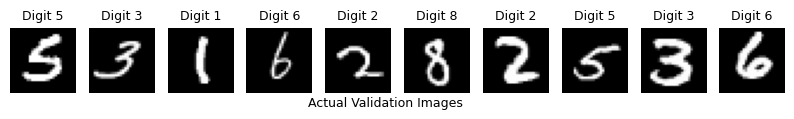

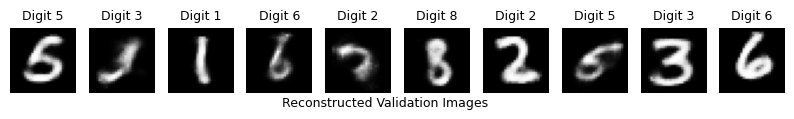

Epoch: 1 -> train_loss: 0.00026508715900558014 | val_loss: 0.00023079607480516037


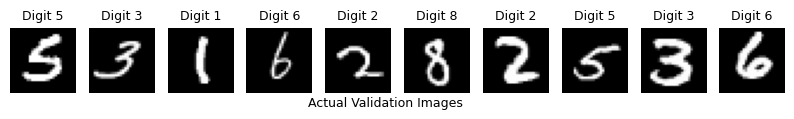

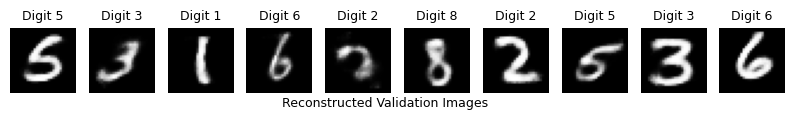

Epoch: 2 -> train_loss: 0.00020588524805174933 | val_loss: 0.00018871143460273741


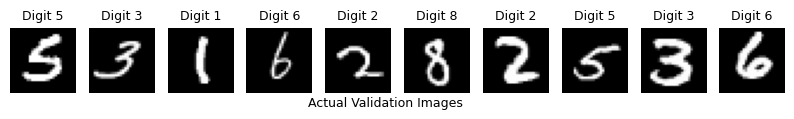

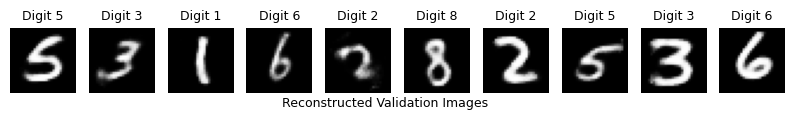

Epoch: 3 -> train_loss: 0.00017218952731194872 | val_loss: 0.0001637378811525802


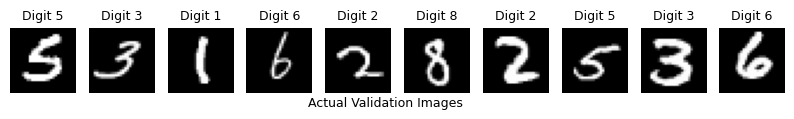

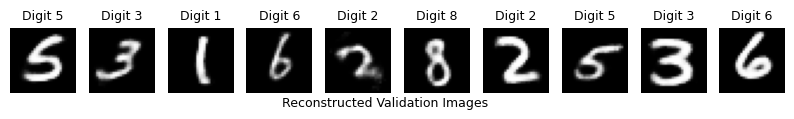

Epoch: 4 -> train_loss: 0.00015238124313246874 | val_loss: 0.00014984707394614816


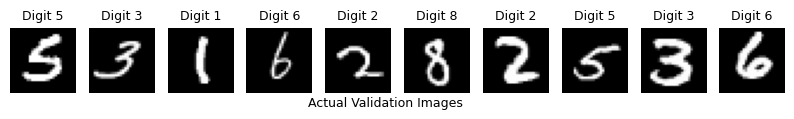

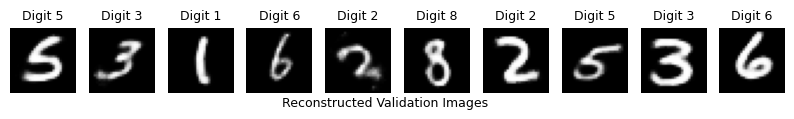

Epoch: 5 -> train_loss: 0.00013983094630142052 | val_loss: 0.00013978613827688


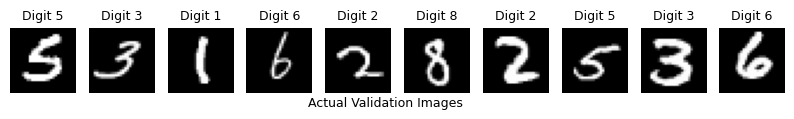

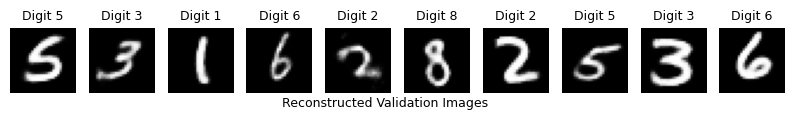

Epoch: 6 -> train_loss: 0.0001305348006318565 | val_loss: 0.0001308453627085934


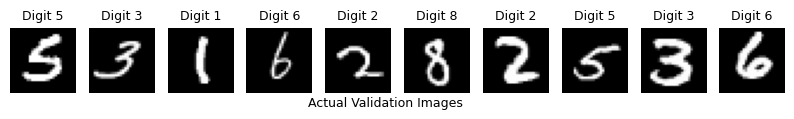

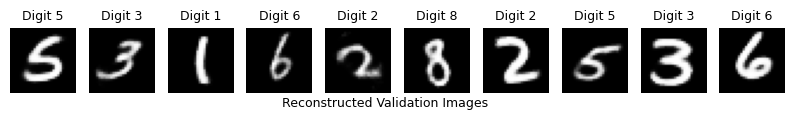

Epoch: 7 -> train_loss: 0.0001226586144141577 | val_loss: 0.00012554023802901308


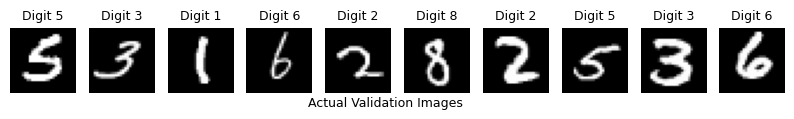

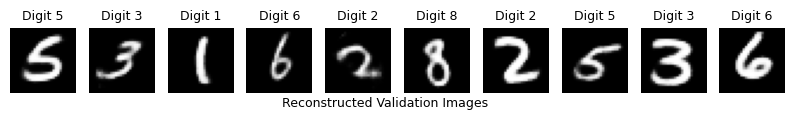

Epoch: 8 -> train_loss: 0.00011650921252590638 | val_loss: 0.00012127537963291009


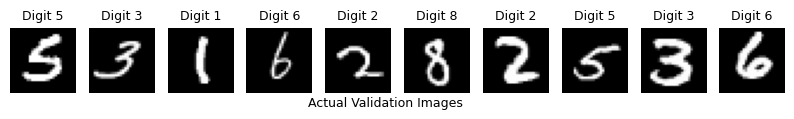

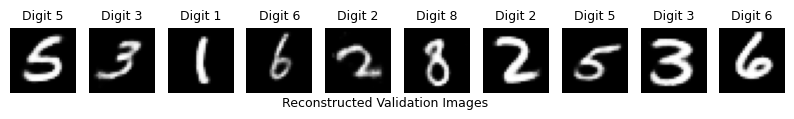

Epoch: 9 -> train_loss: 0.0001112233749590814 | val_loss: 0.00011733276505644123


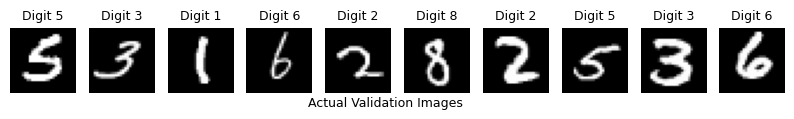

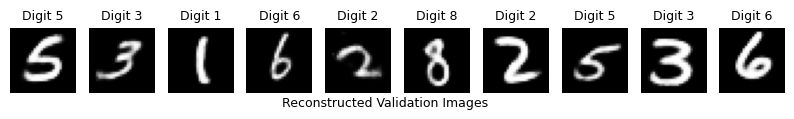

Epoch: 10 -> train_loss: 0.00010627862441146539 | val_loss: 0.00010969863226637244


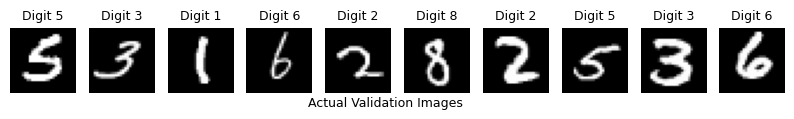

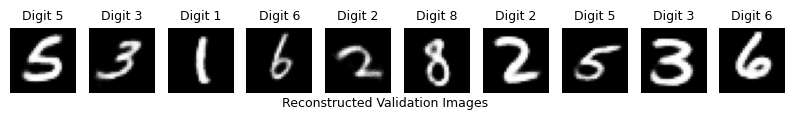

Epoch: 11 -> train_loss: 0.00010233889332179118 | val_loss: 0.00010681750198515753


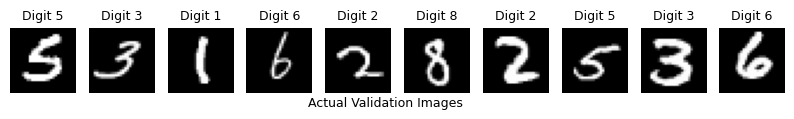

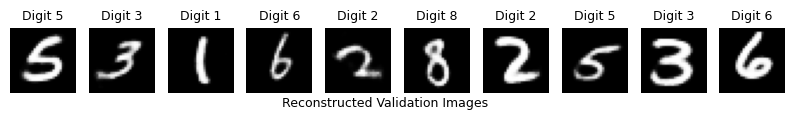

Epoch: 12 -> train_loss: 9.882018004578573e-05 | val_loss: 0.00010531464622666439


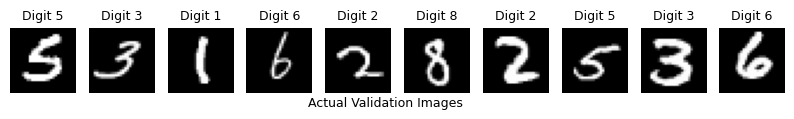

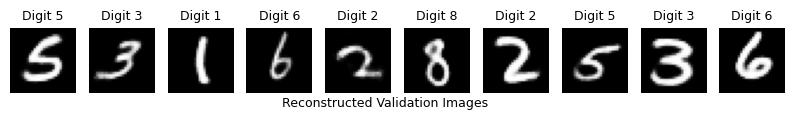

Epoch: 13 -> train_loss: 9.57922702482729e-05 | val_loss: 0.00010402853065170347


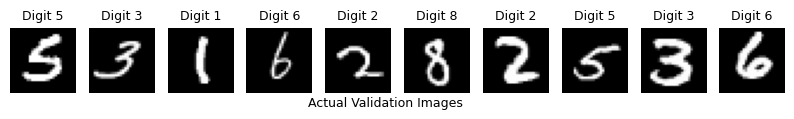

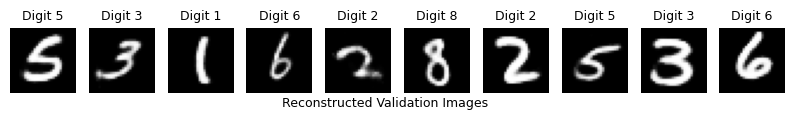

Epoch: 14 -> train_loss: 9.298550298747917e-05 | val_loss: 0.00010007848769115905


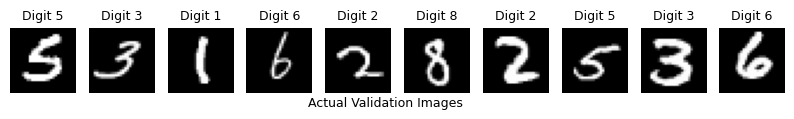

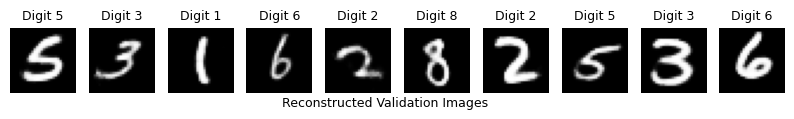

In [11]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)

loss_func = nn.MSELoss()
train_loss_history = []
val_loss_history = []

for epoch in range(EPOCH):
    batch_train_loss = 0
    for (x, y) in train_loader:
        _, decoded = autoencoder(x)
        train_loss = loss_func(decoded, x)         # mean square error
        batch_train_loss += train_loss.item()

        optimizer.zero_grad()                      # clear gradients for this training step
        train_loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                           # apply gradients

    # validation after each training epoch
    batch_val_loss = 0
    for (x, y) in val_loader:
        _, val_decoded = autoencoder(x)
        batch_val_loss += loss_func(val_decoded, x).item()      # mean square error
        val_y = y
        val_x = x

    batch_train_loss /= len(train_dataset)
    batch_val_loss /= len(val_dataset)
    val_loss_history.append(batch_val_loss)
    train_loss_history.append(batch_train_loss)    
    print(f'Epoch: {epoch} -> train_loss: {batch_train_loss} | val_loss: {batch_val_loss}')
    plotDecodedImg(val_x, val_y, val_decoded, val=True)

Both training and validation loss start very high but rapidly decrease over the first few epochs. The training loss decreases faster than the validation loss initially, which is expected as the model overfits to the training data first before generalizing. After around 4 epochs, both losses reach a a same value. Both the training and validation loss curves appear to be converging, which means that the model is not overfitting or underfitting significantly. The validation loss curve closely follows the training loss curve, suggesting that the model is generalizing well to unseen data.

Ovelall, the loss curves suggest that your autoencoder model has been trained successfully on the MNIST dataset, achieving low reconstruction errors on both the training and validation data. The model appears to have learned the underlying patterns in the data well, without overfitting or underfitting significantly.

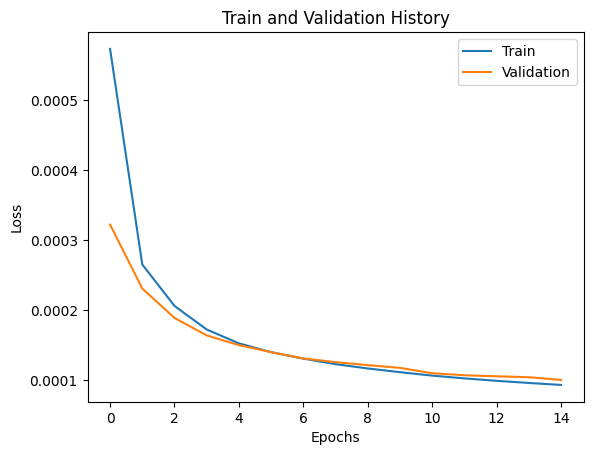

In [12]:
plotStatistics(train_loss_history, val_loss_history, True)

In [13]:
# save the trained model
torch.save(autoencoder.state_dict(), PATH_to_AE)

test_loss: 9.707094335462898e-05


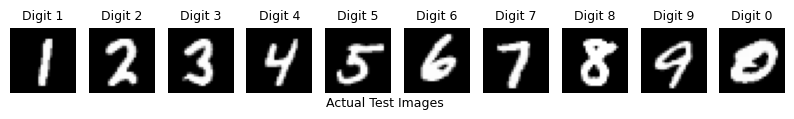

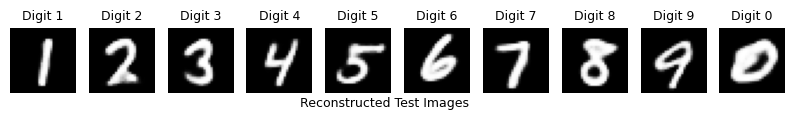

In [14]:
batch_test_loss = 0
for (x, y) in test_loader:
    _, test_decoded = autoencoder(x)
    batch_test_loss += loss_func(test_decoded, x).item()      # mean square error
    test_y = y
    test_x = x

print(f'test_loss: {batch_test_loss/len(test_dataset)}')
plotDecodedImg(test_x, test_y, test_decoded, val=False)

## Classification

The Classifier is a simple feedforward neural network with three fully connected (linear) layers.

**Classifier Architecture:**

- **Input Layer**
    - `fc1 = nn.Linear(input_size, hidden_size1)`: The first fully connected layer transforms the input of size 30 into a 1000-dimensional space.

- **Hidden Layer 1:** 
  - `fc2 = nn.Linear(hidden_size1, hidden_size2)': The second fully connected layer transforms the output of the first hidden layer to into a 500-dimensional space.

- **Hidden Layer 2:** 
  - `fc3 = nn.Linear(hidden_size2, num_classes)': The third fully connected layer transforms the output of the second hidden layer to the number of classes (10 for MNIST).

- **Forward Pass:**
  - `x = nn.functional.relu(self.fc1(x))`: The input x is passed through the first fully connected layer (fc1), followed by a ReLU activation function.
  - `x = nn.functional.relu(self.fc2(x))`: The output of the first layer is passed through the second fully connected layer (fc2), followed by another ReLU activation function.
  -`x = nn.functional.softmax(self.fc3(x), dim=1)`: The output of the second layer is passed through the third fully connected layer (fc3), followed by a softmax activation function. The softmax function converts the raw scores (logits) into probabilities, ensuring that the output values are between 0 and 1 and sum to 1 across the specified dimension (dim=1).

▶︎ Note on Softmax:

The softmax function converts the raw output scores (logits) from the previous layer into probabilities. Each output value is between 0 and 1, and the sum of all output values is 1. This makes it easier to interpret the output as the probability of each class (The probabilities can be interpreted as confidence scores for each class, which is useful for understanding the model's predictions.). in addition, The softmax function normalizes the output logits, ensuring that the outputs are on a comparable scale. This normalization helps in stabilizing the training process and improving convergence. 

The softmax layer is typically used in conjunction with the cross-entropy loss function. Cross-entropy loss measures the difference between the predicted probability distribution and the true distribution (labels). This combination is effective for training classifiers. The softmax function and cross-entropy loss work well with gradient descent optimization, providing smooth gradients that help in efficient training.

In [52]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        #x = self.fc3(x)
        x = nn.functional.softmax(self.fc3(x), dim=1)
        return x

In [53]:
clf = Classifier(input_size=30, hidden_size1=1000, hidden_size2=500, num_classes=10)
print(clf)

Classifier(
  (fc1): Linear(in_features=30, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)


In [54]:
ae = Autoencoder()
ae.load_state_dict(torch.load(PATH_to_AE))

<All keys matched successfully>

In [55]:
def plotPredictedLabel(data, label, predicted, val=True):
    fig, ax = plt.subplots(1, N_TEST_IMG, figsize=(10, 1.5))
    for i in range(N_TEST_IMG):
        # unflatten to show image
        ax[i].imshow(torch.unflatten(data, 1, (28, 28))[i], cmap='gray')
        ax[i].set_title(f'Digit {label[i]}', fontsize='9')
        ax[i].set_xlabel(f'Pred {predicted[i]}', fontsize='9')
        ax[i].set_yticks(())
        ax[i].set_xticks(())
    fig.suptitle(f'Prediction for {"Validation" if val else "Test"} Images', fontsize='9')
    plt.show()

In [56]:
EPOCH = 15
LR = 0.003
MOMEMTUM=0.9

#optimizer = torch.optim.Adam(clf.parameters(), lr=LR)
optimizer = torch.optim.SGD(clf.parameters(), lr=LR, momentum=MOMEMTUM)
loss_func = nn.CrossEntropyLoss()
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(EPOCH):
    batch_train_loss, batch_val_loss, batch_train_acc, batch_val_acc = 0, 0, 0, 0
    for (x, y) in train_loader:
        train_encoded, _ = ae(x)
        train_output = clf(train_encoded)
        
        train_loss = loss_func(train_output, y)
        batch_train_loss += train_loss.item()
        _, predicted = torch.max(train_output, 1)
        batch_train_acc += (predicted == y).sum().item()

        optimizer.zero_grad()                      # clear gradients for this training step
        train_loss.backward()                      # backpropagation, compute gradients
        optimizer.step()                           # apply gradients

    # validation after each training epoch
    for (x, y) in val_loader:
        val_encoded, _ = ae(x)
        val_output = clf(val_encoded)
        
        batch_val_loss += loss_func(val_output, y).item()
        _, predicted = torch.max(val_output, 1)
        batch_val_acc += (predicted == y).sum().item()
        
        val_y = y
        val_x = x
        val_pred = predicted
    
    batch_train_acc /= len(train_dataset)
    batch_train_loss /= len(train_dataset)
    batch_val_acc /= len(val_dataset)
    batch_val_loss /= len(val_dataset)

    val_loss_history.append(batch_val_loss)
    train_loss_history.append(batch_train_loss)    
    val_acc_history.append(batch_val_acc)
    train_acc_history.append(batch_train_acc)    
    
    print(f'Epoch: {epoch} -> train_loss: {batch_train_loss} | val_loss: {batch_val_loss} | train_acc: {batch_train_acc} | val_acc: {batch_val_acc}')

Epoch: 0 -> train_loss: 0.027731327681629746 | val_loss: 0.02587687293688456 | train_acc: 0.7352037037037037 | val_acc: 0.8298333333333333
Epoch: 1 -> train_loss: 0.0255174638805566 | val_loss: 0.02554307303826014 | train_acc: 0.8438703703703704 | val_acc: 0.8411666666666666
Epoch: 2 -> train_loss: 0.025284067006022842 | val_loss: 0.02536827709277471 | train_acc: 0.8525925925925926 | val_acc: 0.8481666666666666
Epoch: 3 -> train_loss: 0.024211424472155393 | val_loss: 0.02396088057756424 | train_acc: 0.9278333333333333 | val_acc: 0.9441666666666667
Epoch: 4 -> train_loss: 0.023862069765726725 | val_loss: 0.023839880088965096 | train_acc: 0.9458333333333333 | val_acc: 0.9503333333333334
Epoch: 5 -> train_loss: 0.023743801331078566 | val_loss: 0.023751408954461414 | train_acc: 0.9515925925925925 | val_acc: 0.9546666666666667
Epoch: 6 -> train_loss: 0.023660218958501462 | val_loss: 0.02367631681760152 | train_acc: 0.9564444444444444 | val_acc: 0.9581666666666667
Epoch: 7 -> train_loss: 0.0

Both training and validation loss start high but rapidly decrease over the first few epochs. The training loss decreases faster than the validation loss initially, which is expected as the model overfits to the training data first before generalizing. Both the training and validation loss curves appear to be converging and the gap between both curves is not significant, which means that the model is not overfitting or underfitting significantly. The validation loss curve closely follows the training loss curve, suggesting that the model is generalizing well to unseen data.

In addition, both training and validation accuracy start low but rapidly increase over the first few epochs. Both the training and validation accuracy curves appear to be converging to a high value and the gap between both curves is not significant, which means that the model is not overfitting or underfitting and the model is generalizing well to unseen data.

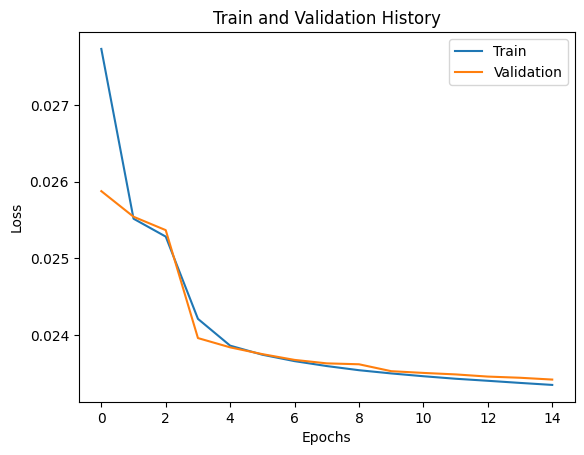

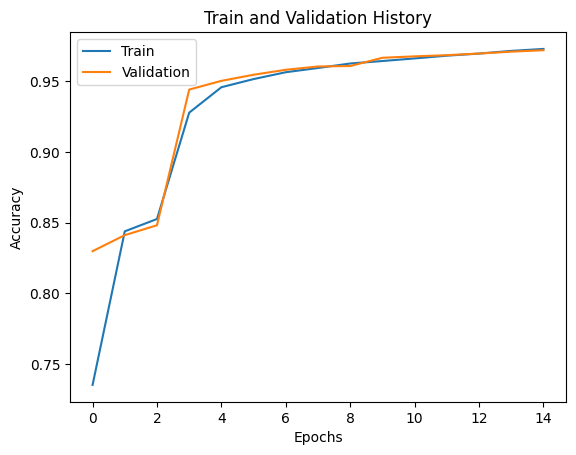

In [57]:
plotStatistics(train_loss_history,val_loss_history, True)
plotStatistics(train_acc_history,val_acc_history, False)

test_loss: 0.02345204166173935 | test_acc: 0.9722


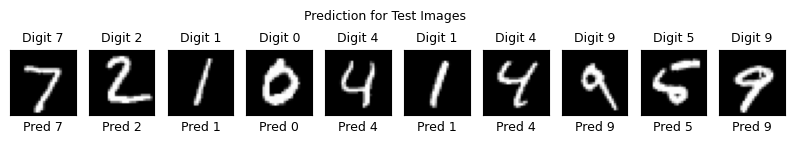

In [58]:
correct, batch_test_loss = 0, 0
test_pred = torch.Tensor([])

for (x, y) in test_loader:
    test_encoded, _ = ae(x)
    test_output = clf(test_encoded)
    batch_test_loss += loss_func(test_output, y).item()
    _, predicted = torch.max(test_output, 1)
    correct += (predicted == y).sum().item()
    test_pred = torch.cat((test_pred, predicted), dim=0)

test_pred = test_pred.type(torch.int)
print(f'test_loss: {batch_test_loss/len(test_dataset)} | test_acc: {correct/len(test_dataset)}')
plotPredictedLabel(test_dataset[:][0], test_dataset[:][1], test_pred, False)

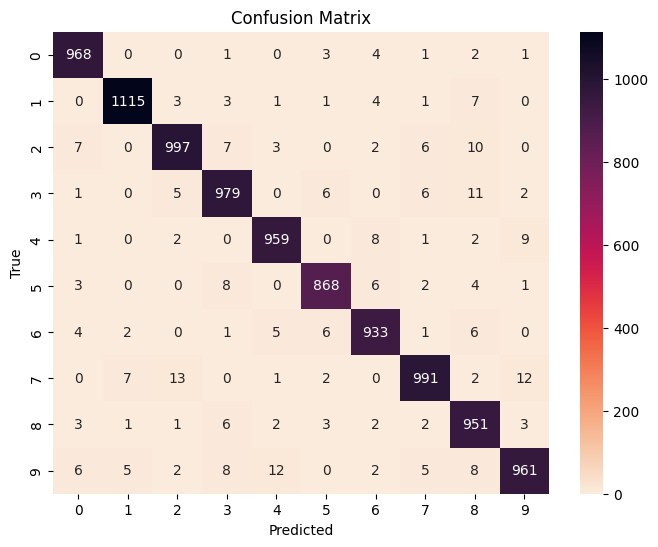

In [59]:
# Calculate the confusion matrix
cm = confusion_matrix(test_dataset[:][1], test_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [67]:
report = classification_report(test_dataset[:][1], test_pred, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.97      0.97      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.95      0.98      0.96       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



The confusion matrix shows that most classifier result for each of the classes are correctly predicted. **Percision** measures the accuracy of the positive predictions (TP) which is the highest for numebr '1'. The lowest percision value is for number '8' which the classifier has sometimes predicted it as '3' and most frequently predicted '8' when the true value was '2' or '3'. **Recall**  measures the ability of the classifier to find all the positive instances which is the lowest for '9' and the highest for '0'. **F1 Score** combined the two and suggest that the netwok is best able to classify '0', '1', and '4' with 0.98 score and least able to classify '9' and '8' with 0.96 score. It is imprtant to note that the darker squares in confustion matrix can not solely suggest a better classification because other factors such as the number of instances of that specific value in the test must be considered.

